# ablation study
How accurate can we make a recurring timer in a linux server?

## pre-requisites

```sh
# python modules
pip install numpy matplotlib pandas
# system deps
sudo apt install curl build-essential
# rust
curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh
```
    

# Sleep vs poll
Comparison in terms of accuracy and wasted CPU cycles


In [1]:
# compile userspace timer test
!cd usr-bl && cargo build --release

    Updating crates.io index
  Downloaded anstream v0.6.20 bytes: 27.4 KB                               
  Downloaded clap v4.5.43                                                  
  Downloaded anstyle-query v1.1.4es: 171.0 KB                              
  Downloaded clap_builder v4.5.43                                          
  Downloaded 4 crates (267.0 KB) in 0.36s                                  
   Compiling crossbeam-utils v0.8.21
   Compiling rayon-core v1.12.1
   Compiling utf8parse v0.2.2
   Compiling anstyle v1.0.11
   Compiling libc v0.2.174
   Compiling colorchoice v1.0.4
   Compiling is_terminal_polyfill v1.70.1
   Compiling anstyle-query v1.1.4
   Compiling strsim v0.11.1
   Compiling either v1.15.0
   Compiling clap_lex v0.7.5
   Compiling cfg-if v1.0.1
   Compiling once_cell v1.21.3         ] 0/30: clap_lex, colorchoice, cf...
   Compiling anstyle-parse v0.2.7      ] 2/30: clap_lex, once_cell, colo...
   Compiling anstream v0.6.20          ] 6/30: clap_lex, once_ce

In [3]:
# stress test cpus
# run on system directly
#!stress-ng -l 50 -c 1 --cpu-method rand

In [4]:
subprocess.run(["perf", "stat", "--", program, "-r", f"{r}" , "-s", f"{interval}", "-a", f"{attempts}"], capture_output=True, text=True)

CompletedProcess(args=['perf', 'stat', '--', 'target/release/bpsleep', '-r', '0', '-s', '10', '-a', '10000'], returncode=255, stdout='', stderr='Error:\nNo permission to enable task-clock event.\n\n\n')

In [4]:
!python3 interval_accuracy.py

The results for an interval of 10 ns are: 
            avg      std        max      min        jit  cpu_cycles
0.000      74ns     44ns    4.227µs     64ns    4.163us   4,880,487
0.001  52.694µs  5.668µs  432.689µs  4.102µs  428.587us  11,072,382
0.010  52.692µs  4.139µs  162.397µs  4.276µs  158.121us  11,500,980
0.100  52.671µs  4.335µs  190.549µs  4.306µs  186.243us  11,941,009
0.200  52.592µs  3.868µs  167.345µs  4.358µs  162.987us  10,468,281
0.300  52.677µs  4.267µs  152.458µs  4.072µs  148.386us  11,161,200
0.400  52.665µs  4.205µs  158.066µs  4.074µs  153.992us  10,642,158
0.500  52.641µs  4.511µs  226.715µs  4.245µs   222.47us  11,090,863
0.600  52.686µs  4.657µs  174.629µs  4.275µs  170.354us  10,687,628
0.700  52.789µs  6.202µs  391.514µs  4.491µs  387.023us  10,973,604
0.800  52.584µs  4.005µs  167.117µs  4.212µs  162.905us  10,830,379
0.900  52.628µs  3.813µs  147.216µs  3.885µs  143.331us  10,758,181
1.000  52.575µs  2.336µs  125.223µs  4.069µs  121.154us  10,364,846
The r

## Plots

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

%matplotlib widget

In [8]:
!pwd

/home/davide/repos/dmem-replication/jupyter/round-accuracy


In [3]:
# fig, ax = plt.subplots()
# cxlnode_noload = pickle.load(open("", "rb"))

cxlnode_noload = pd.read_pickle("results/cxl-tests/cxlnode_10ns-1ms_noload.pkl")
cxlnode_20load = pd.read_pickle("results/cxl-tests/cxlnode_10ns-1ms_20load.pkl")
cxlnode_97load = pd.read_pickle("results/cxl-tests/cxlnode_10ns-1ms_97load.pkl")

number_of_runs = 1000
for i in cxlnode_noload:
    cxlnode_noload[i]["cpu_cycles"] = cxlnode_noload[i]["cpu_cycles"].str.replace("’","").astype(int)/number_of_runs
    
cxlnode_noload.pop(10000000) # remove the 10ms entry, not in other data sets 

for i in cxlnode_20load:
    cxlnode_20load[i]["cpu_cycles"] = cxlnode_20load[i]["cpu_cycles"].str.replace("’","").astype(int)/number_of_runs
    cxlnode_97load[i]["cpu_cycles"] = cxlnode_97load[i]["cpu_cycles"].str.replace("’","").astype(int)/number_of_runs


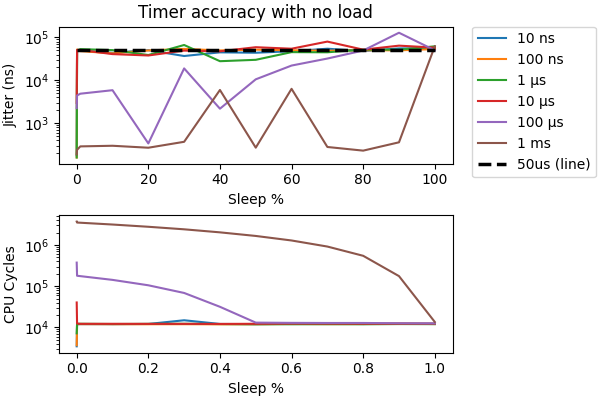

In [10]:
fig, axs = plt.subplots(2,1, layout='constrained', figsize=(6, 4))

def interval_to_unit(interval):
    if interval < 1000:
        return f"{interval} ns"
    if interval < 1000000:
        return f"{int(interval/1000)} µs"
    if interval < 1000000000:
        return f"{int(interval/1000000)} ms"
        

for interval in cxlnode_noload:
    axs[0].plot(cxlnode_noload[interval].index * 100, cxlnode_noload[interval]["jit"], label=f"{interval_to_unit(interval)}")
    axs[1].plot(cxlnode_noload[interval]["cpu_cycles"])

axs[0].plot(cxlnode_noload[10].index * 100, [50000]*len(cxlnode_noload[10].index), label="50us (line)", linestyle="--", color="black", linewidth=2.5)


axs[0].set_title("Timer accuracy with no load")
axs[0].set_xlabel("Sleep %")
axs[0].set_ylabel("Jitter (ns)")

axs[0].set_yscale("log")

axs[1].set_xlabel("Sleep %")
axs[1].set_ylabel("CPU Cycles")
axs[1].set_yscale("log")
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

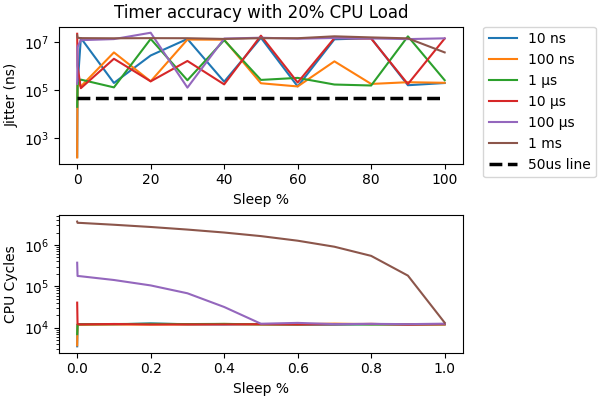

In [28]:
fig, axs = plt.subplots(2,1, layout='constrained', figsize=(6, 4))

def interval_to_unit(interval):
    if interval < 1000:
        return f"{interval} ns"
    if interval < 1000000:
        return f"{int(interval/1000)} µs"
    if interval < 1000000000:
        return f"{int(interval/1000000)} ms"
        

data = cxlnode_20load
for interval in data:
    axs[0].plot(data[interval].index * 100, data[interval]["jit"], label=f"{interval_to_unit(interval)}")
    axs[1].plot(data[interval]["cpu_cycles"])

axs[0].plot(data[10].index * 100, [50000]*len(data[10].index), label="50us line", linestyle="--", color="black", linewidth=2.5)

axs[0].set_title("Timer accuracy with 20% CPU Load")
axs[0].set_xlabel("Sleep %")
axs[0].set_ylabel("Jitter (ns)")

axs[0].set_yscale("log")
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


axs[1].set_xlabel("Sleep %")
axs[1].set_ylabel("CPU Cycles")
axs[1].set_yscale("log")

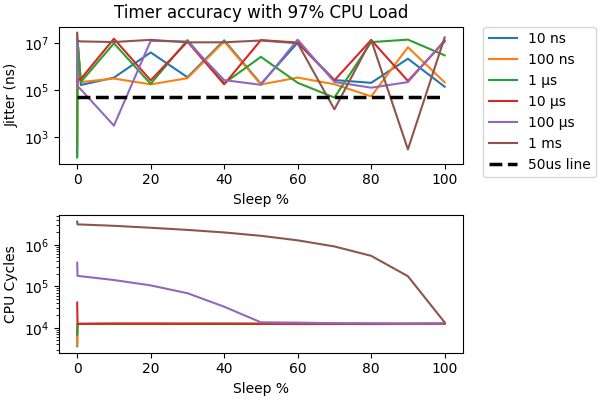

In [11]:
fig, axs = plt.subplots(2,1, layout='constrained', figsize=(6, 4))

def interval_to_unit(interval):
    if interval < 1000:
        return f"{interval} ns"
    if interval < 1000000:
        return f"{int(interval/1000)} µs"
    if interval < 1000000000:
        return f"{int(interval/1000000)} ms"
        

data = cxlnode_97load
for interval in data:
    axs[0].plot(data[interval].index * 100, data[interval]["jit"], label=f"{interval_to_unit(interval)}")
    axs[1].plot(data[interval].index * 100,data[interval]["cpu_cycles"])

axs[0].plot(data[10].index * 100, [50000]*len(data[10].index), label="50us line", linestyle="--", color="black", linewidth=2.5)

axs[0].set_title("Timer accuracy with 97% CPU Load")
axs[0].set_xlabel("Sleep %")
axs[0].set_ylabel("Jitter (ns)")

axs[0].set_yscale("log")
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


axs[1].set_xlabel("Sleep %")
axs[1].set_ylabel("CPU Cycles")
axs[1].set_yscale("log")

In [119]:
cxlnode_97load

{10:            avg       std         max      min         jit  cpu_cycles
 0.000    115.0       7.0       270.0    110.0       160.0    3588.392
 0.001  68108.0  408344.0  12970503.0  10770.0  12959733.0   12420.060
 0.010  55082.0    6165.0    177954.0   9100.0    168854.0   12465.576
 0.100  55099.0   10194.0    358448.0  12610.0    345838.0   12524.479
 0.200  59202.0  128122.0   4105066.0  23200.0   4081866.0   12502.052
 0.300  55147.0   10465.0    370859.0   9780.0    361079.0   12542.594
 0.400  68496.0  420518.0  13358962.0  13530.0  13345432.0   12541.369
 0.500  55178.0    6241.0    207355.0  19071.0    188284.0   12421.641
 0.600  65738.0  334359.0  10632029.0  18250.0  10613779.0   12345.595
 0.700  55131.0    8243.0    285087.0  11400.0    273687.0   12433.705
 0.800  55059.0    6966.0    213465.0   5250.0    208215.0   12319.945
 0.900  57248.0   68578.0   2215021.0  11530.0   2203491.0   12378.834
 1.000  55095.0    5523.0    149594.0   6800.0    142794.0   12480.982,
 

# Round time (mem access + timer latencies) test

In [13]:
import numpy as np
import matplotlib.pyplot as plt


In [14]:
# data in results/round_test*
# round time = 1us
percentiles = [0, 50, 95, 99, 99.99, 100]
linspace = [0,1,2,3,4,5]
local_mem_latencies = [29, 30, 40, 60, 220, 131611]
local_timer_latencies = [30, 1110, 1110, 1170, 12990, 227646]
cxl_mem_latencies = [320, 330,470,620,8661,102812]
cxl_timer_latencies = [30,810,810,820,11350,182415]




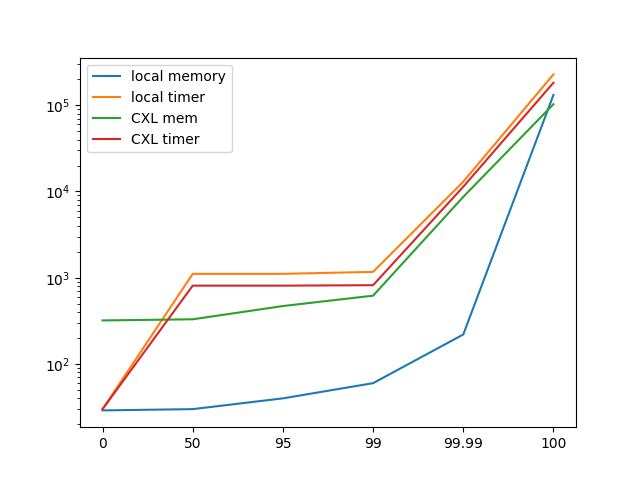

In [26]:
fig, ax = plt.subplots()
ax.plot(linspace,local_mem_latencies,label="local memory")
ax.plot(linspace,local_timer_latencies,label="local timer")
ax.plot(linspace,cxl_mem_latencies,label="CXL mem")
ax.plot(linspace,cxl_timer_latencies, label="CXL timer")

ax.set_yscale("log")
ax.set_xticks(linspace,labels=percentiles)
ax.legend()

# Timer accuracy
How accurate can a **1 microsecond** timer be in Linux? (no memory access, just store a timestamp every time a timer is fired).

## Real time kernel

### config 1


- Ubuntu 22.04  
- Kernel: 6.15.9 real time (PREEMPT_RT) and NO_HZ_FULL enabled  (custom compiled)  
- boot params: `isolcpus=0,1 nohz_full=0,1 intel_pstate=disable intel_idle.max_cstate=0 processor.max_cstate=0 idle=poll default_hugepagesz=1G hugepagesz=1G hugepages=8`
- test: user space busy loop with SCHED_FIFO, max priority (99) 

```bash
dvr0@sws01:~/dmem-replication/jupyter/round-accuracy/usr-bl$ cargo build --release
dvr0@sws01:~/dmem-replication/jupyter/round-accuracy/usr-bl$ sudo taskset -c 1 target/release/timer_test -s 1000 -r 0 -a 100000000
Desired sleep duration of 1000 nanoseconds: 100000000 runs
Min: 1.074µs
Avg: 1.131µs
P50: 1.143us
P99: 1.156us
P999: 1.164us
P9999: 4.39us
Max: 13.049µs
jitter: 11.975us
```

### config 2 

Same as above, not pinned to isolated CPU.

```sh
dvr0@sws01:~/dmem-replication/jupyter/round-accuracy/usr-bl$ cargo build --release
dvr0@sws01:~/dmem-replication/jupyter/round-accuracy/usr-bl$ sudo taskset -c 10 target/release/timer_test -s 1000 -r 0 -a 100000000
Desired sleep duration of 1000 nanoseconds: 100000000 runs
Min: 1.078µs
Avg: 1.123µs
P50: 1.114us
P99: 1.134us
P999: 5.503us
P9999: 13.075us
Max: 52.262µs
jitter: 51.184us

```
### config 3
- Ubuntu 22.04  
- Kernel: 6.15.9 real time (PREEMPT_RT) and NO_HZ_FULL enabled  (custom compiled)  
- boot params: `isolcpus=0,1 nohz_full=0,1 intel_pstate=disable intel_idle.max_cstate=0 processor.max_cstate=0 idle=poll default_hugepagesz=1G hugepagesz=1G hugepages=8`
- test: LKM `hrtimer`. Not pinned to isolated core, default priority (it seems that
there's no convenient way to set high priority to kthreads unless using `chrt` or some tricks)


```sh
dvr0@sws01:~/dmem-replication/jupyter/round-accuracy/lkm-hrtimer6.15$ make && sudo insmod round_accuracy.ko
dvr0@sws01:~/dmem-replication/jupyter/round-accuracy/lkm-hrtimer6.15$ sudo dmesg -wH
[ +36.248675] Timer test results:
[  +0.000006] Min: 0 ns, index: 0
[  +0.000002] P50: 2358 ns, index: 565
[  +0.000001] P90: 2437 ns, index: 629
[  +0.000006] P99: 2748 ns, index: 5173
[  +0.005329] P999: 8342 ns, index: 5626569
[  +0.014399] P9999: 18000 ns, index: 13820131
[  +0.046330] Max: 48608 ns, index: 49260290
[  +0.000004] Reached maximum iterations: 100000000
```


### config 4
- Ubuntu 22.04  
- Kernel: 6.15.9 real time (PREEMPT_RT) and NO_HZ_FULL enabled  (custom compiled)  
- boot params: `isolcpus=0,1 nohz_full=0,1 intel_pstate=disable intel_idle.max_cstate=0 processor.max_cstate=0 idle=poll default_hugepagesz=1G hugepagesz=1G hugepages=8`
- test: LKM `bl` (busyloop). Not pinned to isolated core, default priority.

```sh
dvr0@sws01:~/dmem-replication/jupyter/round-accuracy/lkm-bl$ make
dvr0@sws01:~/dmem-replication/jupyter/round-accuracy/lkm-bl$ sudo insmod round_accuracy.ko
dvr0@sws01:~/dmem-replication/jupyter/round-accuracy/lkm-bl$ sudo dmesg -wH
[Aug11 08:53] Timer test results:
[  +0.000005] Min: 1000 ns, index: 1
[  +0.000002] P50: 1014 ns, index: 152
[  +0.000001] P90: 1017 ns, index: 6
[  +0.000000] P99: 1018 ns, index: 25
[  +0.003870] P999: 2915 ns, index: 4019547
[  +0.011738] P9999: 11706 ns, index: 12396446
[  +0.058992] Max: 100146 ns, index: 57139152
```


### config 5
- Ubuntu 22.04  
- Kernel: 6.15.9 real time (PREEMPT_RT) and NO_HZ_FULL enabled  (custom compiled)  
- boot params: `isolcpus=0,1 nohz_full=0,1 intel_pstate=disable intel_idle.max_cstate=0 processor.max_cstate=0 idle=poll default_hugepagesz=1G hugepagesz=1G hugepages=8`
- test: LKM `bl` (busyloop). Pinned to isolated core, default priority (kthread priority is unclear/hard to set, see above).

```sh
dvr0@sws01:~/dmem-replication/jupyter/round-accuracy/lkm-bl$ make
dvr0@sws01:~/dmem-replication/jupyter/round-accuracy/lkm-bl$ sudo insmod round_accuracy.ko
dvr0@sws01:~/dmem-replication/jupyter/round-accuracy/lkm-bl$ sudo dmesg -wH
[264912.369118] Timer test results:
[264912.369126] Min: 1000 ns, index: 4169
[264912.369127] P50: 1014 ns, index: 3
[264912.369137] P90: 1017 ns, index: 10667
[264912.369198] P99: 1021 ns, index: 56307
[264912.369291] P999: 1482 ns, index: 105815
[264912.369545] P9999: 3684 ns, index: 280951
[264912.428079] Max: 91567 ns, index: 57453610
```

## Standard kernel

### config 6
- Ubuntu 22.04  
- Kernel: 5.15.0-144-generic, no_hz unsupported  
- boot params: `BOOT_IMAGE=/vmlinuz-5.15.0-144-generic root=/dev/mapper/ubuntu--vg-ubuntu--lv ro isolcpus=8-10 nohz_full=8-10 intel_pstate=disable intel_idle.max_cstate=0 processor.max_cstate=0 idle=poll default_hugepagesz=1G hugepagesz=1G hugepages=8`
- test: LKM `hrtimer`. Not pinned to isolated core, default priority 

```sh
dvr0@sws02:~/dmem-replication/jupyter/round-accuracy/lkm-hrtimer$ make
dvr0@sws02:~/dmem-replication/jupyter/round-accuracy/lkm-hrtimer$ sudo insmod round_accuracy.ko
dvr0@sws02:~/dmem-replication/jupyter/round-accuracy/lkm-hrtimer$ sudo dmesg -wH
[ 2649.020743] Timer test results:
[ 2649.020748] Min: 0 ns, index: 0
[ 2649.020749] P50: 1480 ns, index: 19
[ 2649.020750] P90: 1522 ns, index: 72
[ 2649.020753] P99: 1553 ns, index: 1088
[ 2649.021294] P999: 1735 ns, index: 414752
[ 2649.028577] P9999: 3494 ns, index: 5690001
[ 2649.080118] Max: 278858 ns, index: 40603549
[ 2649.080122] Reached maximum iterations: 100000000
```

increased period to 2us

```sh
[Aug11 09:47] Timer test results:
[  +0.000005] Min: 0 ns, index: 0
[  +0.000002] P50: 2000 ns, index: 40
[  +0.000002] P90: 2011 ns, index: 34
[  +0.000004] P99: 2049 ns, index: 2312
[  +0.000188] P999: 2479 ns, index: 137419
[  +0.004347] P9999: 4539 ns, index: 3391521
[  +0.088192] Max: 373557 ns, index: 69443821
[  +0.000006] Reached maximum iterations: 100000000
```

### config 7
- Ubuntu 22.04  
- Kernel: 5.15.0-144-generic, no_hz unsupported  
- boot params: `BOOT_IMAGE=/vmlinuz-5.15.0-144-generic root=/dev/mapper/ubuntu--vg-ubuntu--lv ro isolcpus=8-10 nohz_full=8-10 intel_pstate=disable intel_idle.max_cstate=0 processor.max_cstate=0 idle=poll default_hugepagesz=1G hugepagesz=1G hugepages=8`
- test: Userspace `SCHED_DEADLINE` approach with 10us period on isolated CPU. Scheduler params: give me 9us of runtime every 10us (deadline and period).


```sh
dvr0@sws01:~/dmem-replication/jupyter/round-accuracy/rt-test$ gcc -o sched_dealine.o sched_deadline.c
dvr0@sws01:~/dmem-replication/jupyter/round-accuracy/rt-test$ sudo ./sched_dealine.o 
Timer test results:
Min: 10026 ns, index: 2523625
P50: 10043 ns, index: 46
P90: 10052 ns, index: 0
P99: 10055 ns, index: 13
P999: 10057 ns, index: 391
P9999: 10220 ns, index: 965864
Max: 111432 ns, index: 823513
```

- test: same as above but 1us. Scheduler params: give me 1us of runtime every 1us (deadline and period) which is smallest possible value in sched deadline.
```sh
Timer test results:
Min: 1022 ns, index: 5101683
P50: 1042 ns, index: 5
P90: 1047 ns, index: 18
P99: 1050 ns, index: 2
P999: 1544 ns, index: 10750
P9999: 2030 ns, index: 2944510
Max: 109611 ns, index: 8436714
```
### config 8 
- Ubuntu 22.04  
- Kernel: 5.15.0-144-generic, no_hz unsupported  
- boot params: `BOOT_IMAGE=/vmlinuz-5.15.0-144-generic root=/dev/mapper/ubuntu--vg-ubuntu--lv ro isolcpus=8-10 nohz_full=8-10 intel_pstate=disable intel_idle.max_cstate=0 processor.max_cstate=0 idle=poll default_hugepagesz=1G hugepagesz=1G hugepages=8`
- test: Userspace busy loop. Not isolated, max prio
```sh
dvr0@sws02:~/dmem-replication/jupyter/round-accuracy/usr-bl$ cargo build --release
dvr0@sws02:~/dmem-replication/jupyter/round-accuracy/usr-bl$ sudo target/release/timer_test -s 1000 -r 0 -a 100000000
Desired sleep duration of 1000 nanoseconds: 100000000 runs
Min: 1.077µs
Avg: 1.18µs
P50: 1.121us
P99: 1.143us
P999: 1.15us
P9999: 3.877us
Max: 52.404519ms
jitter: 52403.445us
```

### config 9
- Ubuntu 22.04  
- Kernel: 5.15.0-144-generic, no_hz unsupported  
- boot params: `BOOT_IMAGE=/vmlinuz-5.15.0-144-generic root=/dev/mapper/ubuntu--vg-ubuntu--lv ro isolcpus=8-10 nohz_full=8-10 intel_pstate=disable intel_idle.max_cstate=0 processor.max_cstate=0 idle=poll default_hugepagesz=1G hugepagesz=1G hugepages=8`
- test: Userspace busy loop. Isolated, max prio

```sh
dvr0@sws02:~/dmem-replication/jupyter/round-accuracy/usr-bl$ cargo build --release
dvr0@sws02:~/dmem-replication/jupyter/round-accuracy/usr-bl$ sudo taskset -c 9 target/release/timer_test -s 1000 -r 0 -a 100000000
Desired sleep duration of 1000 nanoseconds: 100000000 runs
Min: 1.076µs
Avg: 1.177µs
P50: 1.117us
P99: 1.142us
P999: 1.15us
P9999: 3.773us
Max: 52.407324ms
jitter: 52406.246us
```

### config 10
- Ubuntu 22.04  
- Kernel: 5.15.0-144-generic, no_hz unsupported  
- boot params: `BOOT_IMAGE=/vmlinuz-5.15.0-144-generic root=/dev/mapper/ubuntu--vg-ubuntu--lv ro isolcpus=8-10 nohz_full=8-10 intel_pstate=disable intel_idle.max_cstate=0 processor.max_cstate=0 idle=poll default_hugepagesz=1G hugepagesz=1G hugepages=8`
- test: Userspace busy loop.

```sh
dvr0@sws02:~/dmem-replication/jupyter/round-accuracy/usr-bl$ cargo build --release
dvr0@sws02:~/dmem-replication/jupyter/round-accuracy/usr-bl$ sudo taskset -c 9 target/release/timer_test -s 1000 -r 0 -a 100000000
Desired sleep duration of 1000 nanoseconds: 100000000 runs
Min: 1.075µs
Avg: 1.117µs
P50: 1.117us
P99: 1.14us
P999: 1.149us
P9999: 3.898us
Max: 23.981µs
jitter: 22.906us
```

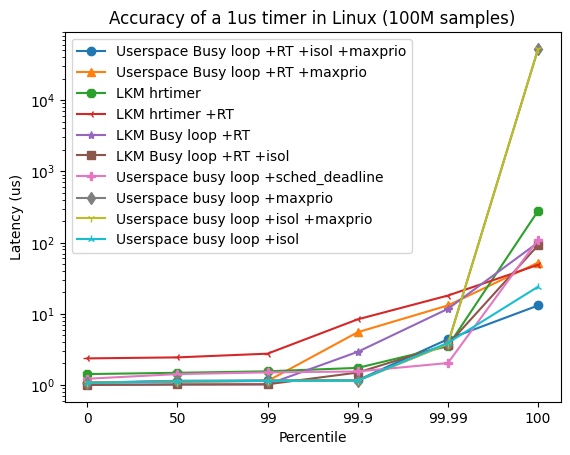

In [1]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

percentiles = [0, 50, 99, 99.9, 99.99, 100]
x = [0,1,2,3,4,5]

config1 = [1.074, 1.143, 1.156, 1.164, 4.39, 13.049]
ax.plot(x, config1, '-o', label="Userspace Busy loop +RT +isol +maxprio")

config2 = [1.078, 1.114, 1.134, 5.503, 13.075, 52.262]
ax.plot(x, config2, '-^', label="Userspace Busy loop +RT +maxprio")

config6 = [1.42, 1.48, 1.553, 1.735, 3.494, 278.858]
ax.plot(x, config6, '-8', label="LKM hrtimer")

config3 = [2.358, 2.437, 2.748, 8.342, 18, 48.608]
ax.plot(x, config3, '-3', label="LKM hrtimer +RT")

config4 = [1, 1.014, 1.017, 2.915, 11.706, 100.146]
ax.plot(x, config4, '-*', label="LKM Busy loop +RT")

config5 = [1, 1.014, 1.021, 1.492, 3.684, 91.567]
ax.plot(x, config5, '-s', label="LKM Busy loop +RT +isol")

config7 = [1.22, 1.42, 1.50, 1.544, 2.030, 109.611]
ax.plot(x, config7, '-P', label="Userspace busy loop +sched_deadline ")

config8 = [1.07, 1.121, 1.143, 1.15, 3.777, 52404.519]
ax.plot(x, config8, '-d', label="Userspace busy loop +maxprio")

config9 = [1.076, 1.117, 1.142, 1.15, 3.773, 52407.234]
ax.plot(x, config9, '-1', label="Userspace busy loop +isol +maxprio")

config10 = [1.075, 1.117, 1.14, 1.149, 3.898, 23.981]
ax.plot(x, config10, '-2', label="Userspace busy loop +isol")

ax.set_title("Accuracy of a 1us timer in Linux (100M samples)")
ax.set_xlabel("Percentile")
ax.set_ylabel("Latency (us)")
ax.set_yscale("log")
ax.set_xticks(x,labels=percentiles)
ax.legend()
